In [1]:
# !unzip ./cranfield.zip

Archive:  ./cranfield.zip
   creating: cranfield/
  inflating: __MACOSX/._cranfield    
  inflating: cranfield/.DS_Store     
  inflating: __MACOSX/cranfield/._.DS_Store  
  inflating: cranfield/cran_queries.json  
  inflating: __MACOSX/cranfield/._cran_queries.json  
  inflating: cranfield/cran_qrels.json  
  inflating: __MACOSX/cranfield/._cran_qrels.json  
  inflating: cranfield/cran_docs.json  
  inflating: __MACOSX/cranfield/._cran_docs.json  
  inflating: cranfield/README.txt    
  inflating: __MACOSX/cranfield/._README.txt  


In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import json

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##DATA-PREPROCESSING Code

In [3]:
# Code for data preprocessing
def data_preprocess(doc):
  # Tokenize and convert to lower case 
  tokens = [w.lower() for w in word_tokenize(doc)]
  # Remove punctuation and non-alphabetic characters, filter stop words, and stem
  stop_words = set(stopwords.words('english'))
  porter = PorterStemmer()
  words = [porter.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
  return words

##EVALUATION Code

In [4]:

import math
import os

# Add your import statements here
from collections import defaultdict

class Evaluation():
    def __init__(self):
      self.qr=None #This dictionary holds the list of relevant documents for a particular query
    def build_qr(self,q_rels):
      #This function populates the self.qr dictionary which has relevant document lists as values and
      #query ids as keys of the dictionary
      qr = defaultdict(list)
      for dc in q_rels:
        qr[int(dc['query_num'])].append(int(dc['id']))
      self.qr=qr
    def get_docid(self,query_id,qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
      return doc_id

    def get_rel_score(self, query_id,element, qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      rel_score = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
          if k == "position":
            # Measuring the relevance score in a scale of 0-3 where integer with higher value has greater relevance
            rel_score.append(4-int(v))

      relavant_score = rel_score[doc_id.index(element)]
      return relavant_score

    def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The precision value as a number between 0 and 1
      """

      precision = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment precision count by 1.
          if str(element) in true_doc_IDs:
            precision = precision + 1
        count = count + 1
      if k== 0:
        precision = 1
      else:
        # Dividing precision by number of documents retrieved at rank 'k'
        precision = precision / k

      return precision


    def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean precision value as a number between 0 and 1
      """

      meanPrecision = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryPrecision(l, query_ids[n], doc_id, k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanPrecision = 1
      else:
        # Finding the average of all precision values corresponding to different queries
        meanPrecision = sum / len(doc_IDs_ordered)
      return meanPrecision


    def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The recall value as a number between 0 and 1
      """

      recall = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment recall count by 1.
          if str(element) in true_doc_IDs:
            recall = recall + 1
        count = count + 1
      if len(true_doc_IDs) == 0:
        recall = 1
      else:
        # Dividing recall by number of relevant documents
        recall = recall / len(true_doc_IDs)

      return recall


    def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean recall value as a number between 0 and 1
      """

      meanRecall = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryRecall(l,query_ids[n],doc_id,k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanRecall = 1
      else:
        # Finding the average of all recall values corresponding to different queries
        meanRecall = sum / len(doc_IDs_ordered)
      return meanRecall

    def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The fscore value as a number between 0 and 1
      """

      fscore = -1

      #Fill in code here
      precision = self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      recall = self.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      # This will happen when there are no relevant documents in top k results
      if precision + recall == 0:
        fscore = 0
      else:
        fscore = (2 * precision * recall) / (precision + recall)

      return fscore

    def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean fscore value as a number between 0 and 1
      """

      meanFscore = -1

      # Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryFscore(l, query_ids[n], doc_id, k)
        n = n + 1
      # Finding the average of all fscore values corresponding to different queries
      meanFscore = sum / len(doc_IDs_ordered)
      return meanFscore


    def queryNDCG(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of nDCG of the Information Retrieval System
      at given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The nDCG value as a number between 0 and 1
      """

      nDCG = -1

      #Fill in code here
      DCG = 0
      IDCG = 0
      #path=os.path.join(os.getcwd(),"cranfield","cran_qrels.json")
      qrels = json.load(open('/content/cranfield/cran_qrels.json', 'r'))[:]
      count = 1
      for element in query_doc_IDs_ordered:
        if count <= k:
          if str(element) in true_doc_IDs:
            DCG = DCG + (self.get_rel_score(query_id, str(element), qrels) / math.log2(query_doc_IDs_ordered.index(element) + 2))
          count = count + 1
      count = 1
      for element in true_doc_IDs:
        if count <= k:
          IDCG = IDCG + (self.get_rel_score(query_id,element,qrels) / math.log2(count + 1))
          count = count + 1
      # When there are no documents in the ideally relevant to the query then there are no documents to display.
      # Thus the relevance score is 1.
      if IDCG == 0:
        IDCG = 1
      nDCG = DCG / IDCG
      return nDCG


    def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of nDCG of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean nDCG value as a number between 0 and 1
      """

      meanNDCG = -1

      #Fill in code here
      n = 0
      sum = 0
      qrels = sorted(qrels, key=lambda i: (i['position']))
      for l in doc_IDs_ordered:
        if n==len(query_ids): break
        result = list(filter(lambda query: query['query_num'] == str(query_ids[n]), qrels))
        true_doc_IDs = []
        for d in result:
          for ky, val in d.items():
            if ky == "id":
              true_doc_IDs.append(val)
        nDCG=self.queryNDCG(l, query_ids[n], true_doc_IDs, k)
        sum = sum + nDCG
        n = n + 1
      # Finding the average of all nDCG values corresponding to different queries
      meanNDCG = sum/len(doc_IDs_ordered)
      return meanNDCG


    def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of average precision of the Information Retrieval System
      at a given value of k for a single query (the average of precision@i
      values for i such that the ith document is truly relevant)

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The average precision value as a number between 0 and 1
      """

      avgPrecision = -1

      #Fill in code here
      pdl=query_doc_IDs_ordered
      rdl=true_doc_IDs
      for j in range(len(pdl)):
        if pdl[j] in rdl:
          pdl[j] = 1
        else:
          pdl[j] = 0
      ap = 0
      for j in range(len(pdl)):
        ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
      ap /= len(pdl)
      avgPrecision=ap
      return avgPrecision


    def meanAveragePrecision(self, doc_IDs_ordered, query_ids, q_rels, k):
      """
      Computation of MAP of the Information Retrieval System
      at given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The MAP value as a number between 0 and 1
      """

      meanAveragePrecision = -1

      #Fill in code here
      MAP = 0
      # preprocess q_rels
      self.build_qr(q_rels)
      qr = self.qr

      for i in range(len(query_ids)):
        # print(len(doc_IDs_ordered_all),len(query_ids))
        pdl = doc_IDs_ordered[i][:k]
        rdl = qr[int(query_ids[i])]
        #print(pdl[:10], rdl)
        for j in range(len(pdl)):
          if pdl[j] in rdl:
            pdl[j] = 1
          else:
            pdl[j] = 0
        ap = 0
        for j in range(len(pdl)):
          ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
        ap /= len(pdl)
        MAP += ap
      MAP /= len(query_ids)
      meanAveragePrecision=MAP


      return meanAveragePrecision



##DATASET Load

In [5]:
import json
doc_json = json.load(open('/content/cranfield/cran_docs.json', 'r'))
# docs,doc_ids=[doc['body'] for doc in doc_json],[doc['id'] for doc in doc_json]
docs = []
doc_ids = []
for doc in doc_json:
  docs.append(doc['body'])
  doc_ids.append(doc['id'])
query_json = json.load(open('/content/cranfield/cran_queries.json', 'r'))
# qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
querys = []
query_ids = []
for query in query_json:
  querys.append(query['query'])
  query_ids.append(query['query number'])

# print(len(dids),len(qids))
qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))

In [6]:
len(docs)

1400

##SAVE Results in CSV

In [7]:
def save_results(model_name,result_list):
  rf=open(str(model_name)+'.csv','w')
  rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
  for x in result_list:
    rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
  rf.close()

In [8]:
eval = Evaluation()

##VSM IR

In [9]:
def ir_vsm(k):
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.8)
  d_vecs_vsm=vectorizer.fit_transform(docs).todense()
  q_vecs_vsm=vectorizer.transform(querys).todense()
  
  B=sklearn.metrics.pairwise.cosine_similarity(np.array(q_vecs_vsm),np.array(d_vecs_vsm))

  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(B[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=doc_ids[y]
      j+=1
  pred_doc_list=pred_ids.tolist()
  results_VSM=[]
  for i in range(20):
    #for considering only top 10 retrievals
    s=i*10
    e=s+10
    m_AP=eval.meanAveragePrecision(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_nDCG=eval.meanNDCG(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_P=eval.meanPrecision(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_R=eval.meanRecall(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_FS=eval.meanFscore(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    results_VSM.append([m_AP,m_nDCG,m_P,m_R,m_FS])
    
  print('Using VSM - k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pred_doc_list,query_ids,qrels,k)))
  if k==3:
    save_results('VSM',results_VSM)
  return results_VSM,eval.meanNDCG(pred_doc_list,query_ids,qrels,k),eval.meanAveragePrecision(pred_doc_list,query_ids,qrels,k),eval.meanRecall(pred_doc_list,query_ids,qrels,k),eval.meanFscore(pred_doc_list,query_ids,qrels,k)



###IR_VSM Results

In [10]:
r_vsm = [ir_vsm(i) for i in range(1,8)]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 1 nDCG: 0.42352941176470577


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 2 nDCG: 0.3961373824484117


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 3 nDCG: 0.3860411171915023


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 4 nDCG: 0.3795043518361303


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 5 nDCG: 0.3807100912216239


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 6 nDCG: 0.3856648693763492


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

Using VSM - k: 7 nDCG: 0.3929186298367881


##LSA IR

In [11]:
def ir_lsa(k,components):
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.8,ngram_range=(1,2))
  svd_model = TruncatedSVD(n_components=components,         
                          algorithm='randomized',
                          n_iter=10)
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  d_vecs=svd_transformer.fit_transform(docs)
  q_vecs=svd_transformer.transform(querys)
  A=sklearn.metrics.pairwise.cosine_similarity(q_vecs,d_vecs)
  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=doc_ids[y]
      j+=1
  pred_doc_list=pred_ids.tolist()
  results_LSA=[]
  for i in range(20):
    #for considering only top 10 retrievals
    s=i*10
    e=s+10
    m_AP=eval.meanAveragePrecision(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_nDCG=eval.meanNDCG(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_P=eval.meanPrecision(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_R=eval.meanRecall(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    m_FS=eval.meanFscore(pred_doc_list[s:e],query_ids[s:e],qrels,k)
    results_LSA.append([m_AP,m_nDCG,m_P,m_R,m_FS])
    
  print('Using LSA - k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pred_doc_list,query_ids,qrels,k)))
  if k==3:
    save_results('LSA',results_LSA)
  return results_LSA,eval.meanNDCG(pred_doc_list,query_ids,qrels,k),eval.meanAveragePrecision(pred_doc_list,query_ids,qrels,k),eval.meanRecall(pred_doc_list,query_ids,qrels,k),eval.meanFscore(pred_doc_list,query_ids,qrels,k)



###IR_LSA Results

In [12]:
r_lsa_500 = [ir_lsa(i,500) for i in range(1,8)] #500 components

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 1 nDCG: 0.4392156862745097


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 2 nDCG: 0.42205509521189766


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 3 nDCG: 0.4101447009910902


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 4 nDCG: 0.39854536064653917


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 5 nDCG: 0.3936185658907521


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 6 nDCG: 0.4012388082731412


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 7 nDCG: 0.40907431685435286


In [13]:
r_lsa_300 = [ir_lsa(i,300) for i in range(1,8)] #300 components

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 1 nDCG: 0.43921568627450974


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 2 nDCG: 0.4149262577108393


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 3 nDCG: 0.39928000378238954


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 4 nDCG: 0.3964910714716868


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 5 nDCG: 0.396853118612883


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 6 nDCG: 0.3980682058894959


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using LSA - k: 7 nDCG: 0.40770777920430623


##LSA with QE IR

In [14]:
def getsyn(x,k,v,wsim): #getsyn(x,k1+1,v,wsim):
  # Parameters:
  # x: the word for which sunonyms are required
  # k: specifies the number of top k synonyms required.
  # v: specifies the vocabulary list.
  # wsim: word similarity matrix for the corresponding vocabulary v
  # returns a list of top-k synonyms

  if x in v:
    i= v.index(x)
    y = np.argsort(wsim[i]).T[::-1][:k]
    ans=[v[i] for i in y]
    return ans
  else:
    return []

def ir_lsaqe(k,k1,k2,components):
  # Parameters
  # k: top k retireval results
  # k1: number of additional token to be added for every query token randomly chosen
  # k2: Specfies how many new terms to add to the final expanded query.

  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9)
  svd_model = TruncatedSVD(n_components=components,         
                          algorithm='randomized',
                          n_iter=10)
  #We define the pipeline where we first find the tfidf scores and then we do the svd decomposition.
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  # We perform the opertions specified in the pipeline
  dvecs=svd_transformer.fit_transform(docs)
  # The wsim matix is used for query expansion.
  wsim=sklearn.metrics.pairwise.cosine_similarity(svd_model.components_.T,svd_model.components_.T)
  v=vectorizer.get_feature_names_out()
  
  stop_words = set(stopwords.words('english')) 
  # This is where we perform query expansion.
  import random
  exp_querys=[0 for i in range(len(querys))]
  for i in range(len(querys)):
    new_qr=querys[i]
    tkns=nltk.word_tokenize(querys[i])
    random.shuffle(tkns)
    for x in tkns :
      k2=k2-1
      if k2<=0: break
      if x not in stop_words:
        try:
          new_qr+=(' '+' '.join(getsyn(x,k1+1,v,wsim)[1:]))
        except Exception:
          pass
   
    exp_querys[i]=new_qr
  # from scipy.sparse import csr_matrix
 
  qvecs=svd_transformer.transform(exp_querys)
  
  A=sklearn.metrics.pairwise.cosine_similarity(qvecs,dvecs)
  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=doc_ids[y]
      j+=1
  pdl=pred_ids.tolist()
  results_LSAQE=[]
  for i in range(20):
    s=i*10
    e=s+10
    results_LSAQE.append([eval.meanAveragePrecision(pdl[s:e],query_ids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],query_ids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],query_ids[s:e],qrels,k),eval.meanRecall(pdl[s:e],query_ids[s:e],qrels,k),eval.meanFscore(pdl[s:e],query_ids[s:e],qrels,k)])
  print('Using new method with query expansion- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,query_ids,qrels,k)))
  if k==3:
    save_results('LSA_QE',results_LSAQE)
  return results_LSAQE,eval.meanNDCG(pdl,query_ids,qrels,k),eval.meanAveragePrecision(pdl,query_ids,qrels,k),eval.meanRecall(pdl,query_ids,qrels,k),eval.meanFscore(pdl,query_ids,qrels,k)

###IR_LSAQE Results

In [15]:
r_lsaqe = [ir_lsaqe(i,2,3,350) for i in range(1,8)] 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 1 nDCG: 0.42614379084967313


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 2 nDCG: 0.404338509196046


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 3 nDCG: 0.3914985492483339


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 4 nDCG: 0.3885562093819162


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 5 nDCG: 0.38878683826532434


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 6 nDCG: 0.3906649057570489


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 7 nDCG: 0.39987861486016785


In [16]:
r_lsaqe_5 = [ir_lsaqe(i,5,9,350) for i in range(1,8)] 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 1 nDCG: 0.42614379084967313


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 2 nDCG: 0.40220449984823003


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 3 nDCG: 0.39355354991680075


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 4 nDCG: 0.3880393889100264


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 5 nDCG: 0.38865956755189884


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 6 nDCG: 0.39270684985781934


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 7 nDCG: 0.39751897164107636


In [17]:
r_lsaqe_8 = [ir_lsaqe(i,8,20,350) for i in range(1,8)] 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 1 nDCG: 0.4313725490196078


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 2 nDCG: 0.3994847817710369


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 3 nDCG: 0.38908832550290845


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 4 nDCG: 0.3919818082441478


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 5 nDCG: 0.3882356263561654


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 6 nDCG: 0.3932573519853069


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using new method with query expansion- k: 7 nDCG: 0.39977759225011705


##COMPARISON VISUALIZATION

In [20]:
def compare_models_print_comparison_graph(measure='all'):
  #measure can take 'nDCG', 'm_Precision','m_Recall','m_Fscore','all' as values
  import matplotlib.pyplot as plt
  eval_measure ={'nDCG':1,'m_Precision':2,'m_Recall':3,'m_Fscore':4}
  if str(measure)!='all':
    p=eval_measure[str(measure)]
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_vsm], label = "VSM")
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsa_500], label = "LSA_500Comp")
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsa_300], label = "LSA_300Comp")
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsaqe], label = "LSA + QE")
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsaqe_5], label = "LSA + QE_5syn")
    plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsaqe_8], label = "LSA + QE_8syn")
    plt.xlabel('rank - k')
    plt.ylabel(str(measure))
    plt.title('Comparison of '+str(measure)+' scores ')
    plt.legend()
    plt.show()
  else:
    for p in range(1,5):
      plt.plot([i for i in range(1,8) ], [w[p] for w in r_vsm], label = "VSM")
      plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsa_500], label = "LSA_500Comp")
      plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsa_300], label = "LSA_300Comp")
      plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsaqe], label = "LSA + QE")
      plt.plot([i for i in range(1,8) ], [w[p] for w in r_lsaqe_8], label = "LSA + QE_8syn")
      meas=[l for l in eval_measure if eval_measure[l]==p]
      plt.xlabel('rank - k')
      plt.ylabel(str(meas[0]))
      plt.title('Comparison of '+str(meas[0])+' scores ')
      plt.legend()
      plt.grid(linestyle = '--', linewidth = 0.5)
      plt.savefig(str(meas[0])+'.eps')
      plt.show()
      plt.close()


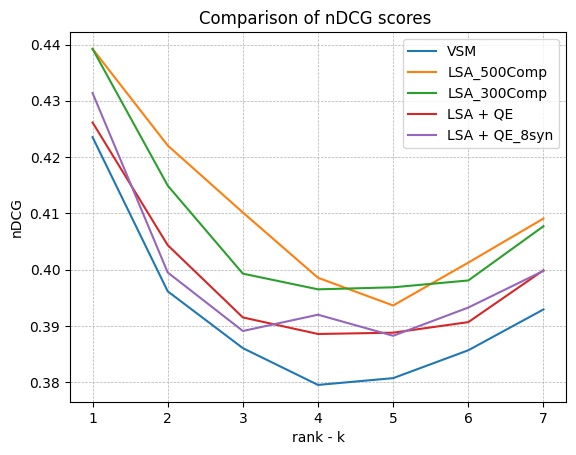

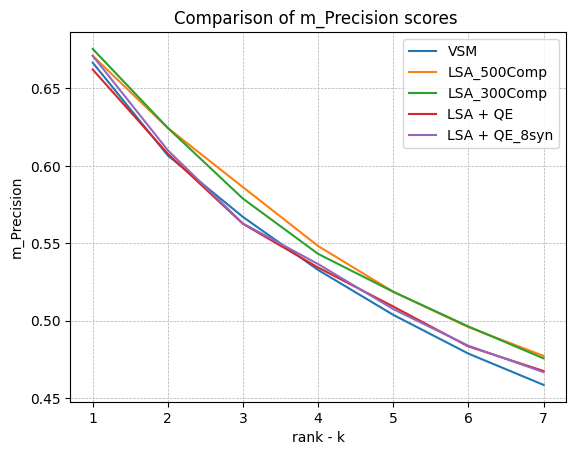

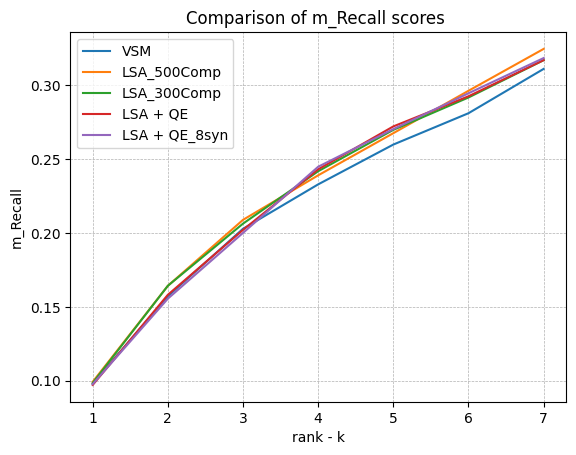

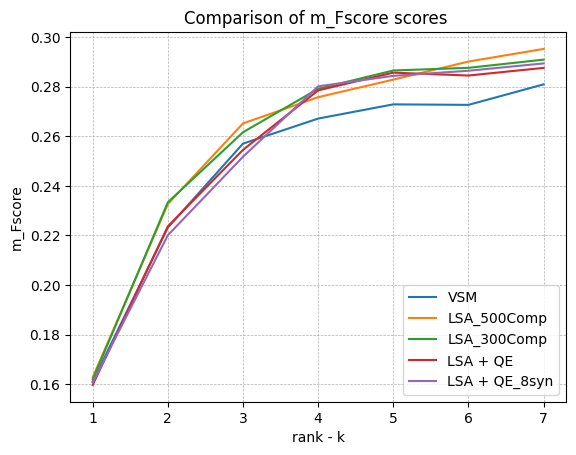

In [21]:
compare_models_print_comparison_graph(measure='all') #measure can take 'nDCG', 'm_Precision','m_Recall','m_Fscore','all' as values